In [46]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor

from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
if os.path.exists("./tensor_y.npy"):
    os.remove("./tensor_y.npy")
if os.path.exists("./tensor_x.npy"):
    os.remove("./tensor_x.npy")
if os.path.exists("./val_tensor_x.npy"):
    os.remove("./val_tensor_x.npy")
if os.path.exists("./val_tensor_y.npy"):
    os.remove("./val_tensor_y.npy")

In [48]:
epochs = 10
batch_size = 16
lr = 1e-3

alpha = 0.1

resize_height = 256
resize_width = 256

ratio = 4
train_val_split_perc = 0.9
val_test_split_perc = 0.5

In [49]:
class Generator(keras.utils.Sequence):
    def __init__(self, x: list, y: list):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        return x, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()

In [50]:
def preprocessing(path, ratio, resize_height, resize_width):
    y = tf.keras.utils.load_img(path)
    y = tf.keras.utils.img_to_array(y)
    y = tf.image.resize(y,
                        [resize_height, resize_width],
                        'bicubic',
                        antialias=True,
                        )
    height, width, _ = y.shape
    x = tf.image.resize(y,
                        [height // ratio, width // ratio],
                        'bicubic',
                        antialias=True,
                        )
    x = x / 255.0
    y = y / 255.0
    return x, y

In [51]:
img_paths = []
val_img_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/div2k-dataset/DIV2K_train_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/div2k-dataset/DIV2K_valid_HR'):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
print('Dataset dimension: ', len(img_paths))

val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]
print('Training: ', len(img_paths))

Dataset dimension:  900
Training:  810


In [52]:
if not (os.path.exists('./tensor_x.npy')) or not (os.path.exists('./tensor_y.npy')):

    img_lr = []
    img_hr = []

    for i in tqdm(range(len(img_paths))):
        x, y = preprocessing(img_paths[i], ratio, resize_height, resize_width)
        img_lr.append(x)
        img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(img_lr).numpy()
    tensor_y = tf.convert_to_tensor(img_hr).numpy()
    tensor_x.shape

    np.save('./tensor_x.npy', tensor_x)
    np.save('./tensor_y.npy', tensor_y)
    img_lr = tensor_x
    img_hr = tensor_y
else:
    img_lr = np.load('./tensor_x.npy')
    img_hr = np.load('./tensor_y.npy')


100%|██████████| 810/810 [02:28<00:00,  5.44it/s]


In [53]:
if not (os.path.exists('./val_tensor_x.npy')) or not (os.path.exists('./val_tensor_y.npy')):

    val_img_lr = []
    val_img_hr = []

    for i in tqdm(range(len(val_img_paths))):
        x, y = preprocessing(val_img_paths[i], ratio, resize_height * 2, resize_width * 2)
        val_img_lr.append(x)
        val_img_hr.append(y)
    
    val_tensor_x = tf.convert_to_tensor(val_img_lr).numpy()
    val_tensor_y = tf.convert_to_tensor(val_img_hr).numpy()

    np.save('./val_tensor_x.npy', val_tensor_x)
    np.save('./val_tensor_y.npy', val_tensor_y)
    val_img_lr = tensor_x
    val_img_hr = tensor_y
else:
    val_img_lr = np.load('./val_tensor_x.npy')
    val_img_hr = np.load('./val_tensor_y.npy')

100%|██████████| 90/90 [00:17<00:00,  5.12it/s]


In [54]:
train_generator = Generator(img_lr, img_hr)
val_generator = Generator(val_img_lr[:floor(val_img_lr.shape[0] * val_test_split_perc)], val_img_hr[:floor(val_img_lr.shape[0] * val_test_split_perc)])
test_generator = Generator(val_img_lr[floor(val_img_lr.shape[0] * val_test_split_perc):], val_img_hr[floor(val_img_lr.shape[0] * val_test_split_perc):])

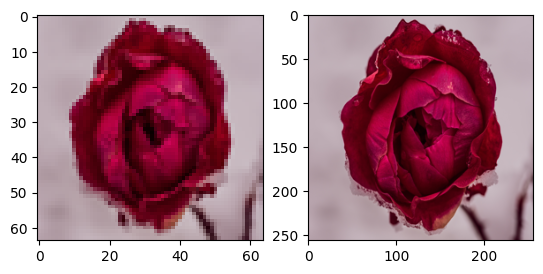

In [55]:
x, y = train_generator[55]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)

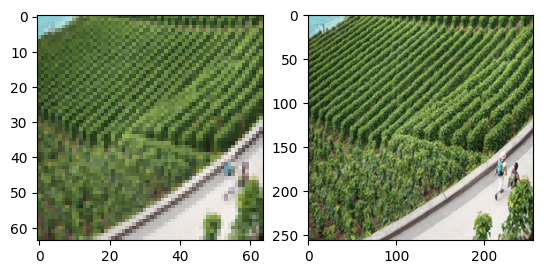

In [56]:
x, y = train_generator[50]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)

In [57]:
train_dataset = tf.data.Dataset.from_generator(train_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)

train_dataset = train_dataset.prefetch(4)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_generator) + 1, reshuffle_each_iteration=True)


In [58]:
val_dataset = tf.data.Dataset.from_generator(val_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
val_dataset = val_dataset.prefetch(4)
val_dataset = val_dataset.cache()

In [59]:
test_dataset = tf.data.Dataset.from_generator(test_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
test_dataset = test_dataset.prefetch(4)
test_dataset = test_dataset.cache()

## Custom Loss Function Definiton

In [60]:
@tf.function
def MeanGradientError(targets, outputs):
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])
    
     # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))
    
     # square
    output_gradients = tf.math.add(output_gradient_x, output_gradient_y)
    target_gradients = tf.math.add(target_gradient_x, target_gradient_y)

    # compute mean gradient error
    mge = tf.keras.metrics.mean_absolute_error(output_gradients, target_gradients)

    return mge


In [61]:
@tf.function
def overall_loss_func(y_true, y_pred):
    mae_loss = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mge_loss = MeanGradientError(y_true, y_pred)
    return mae_loss + alpha * mge_loss

## Model implementation

In [62]:
def SR_model(upscale_factor=4, channels=3):
    conv_args = {
        "activation": "relu",
        "padding": "same",
    }
    inputs = layers.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [63]:
net = SR_model()
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 64)    4864      
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 48)    13872     
                                                                 
 tf.nn.depth_to_space_2 (TF  (None, None, None, 3)     0         
 OpLambda)                                                       
                                                           

In [64]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=overall_loss_func, metrics=['mae', MeanGradientError])

## Training 

In [65]:
history = net.fit(
        x = train_dataset,
        epochs = epochs,
        verbose = 1,
        validation_data = val_dataset
)

Epoch 1/20
51/51 [==============================] - 48s 891ms/step - loss: 0.7227 - mae: 0.2451 - MeanGradientError: 4.7758 - val_loss: 0.6376 - val_mae: 0.1787 - val_MeanGradientError: 4.5894
Epoch 2/20
51/51 [==============================] - 43s 849ms/step - loss: 0.5536 - mae: 0.1429 - MeanGradientError: 4.1070 - val_loss: 0.5089 - val_mae: 0.1194 - val_MeanGradientError: 3.8951
Epoch 3/20
51/51 [==============================] - 44s 859ms/step - loss: 0.4911 - mae: 0.1067 - MeanGradientError: 3.8436 - val_loss: 0.4859 - val_mae: 0.1015 - val_MeanGradientError: 3.8436
Epoch 4/20
51/51 [==============================] - 42s 831ms/step - loss: 0.4488 - mae: 0.0797 - MeanGradientError: 3.6915 - val_loss: 0.4420 - val_mae: 0.0720 - val_MeanGradientError: 3.6998
Epoch 5/20
51/51 [==============================] - 46s 910ms/step - loss: 0.4289 - mae: 0.0711 - MeanGradientError: 3.5784 - val_loss: 0.4216 - val_mae: 0.0688 - val_MeanGradientError: 3.5280
Epoch 6/20
51/51 [=================

## Visualization of training curves

dict_keys(['loss', 'mae', 'MeanGradientError', 'val_loss', 'val_mae', 'val_MeanGradientError'])


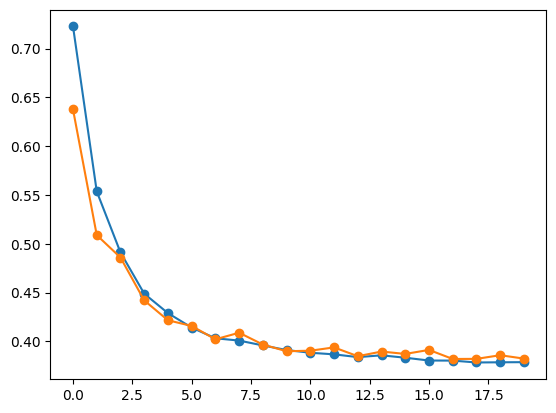

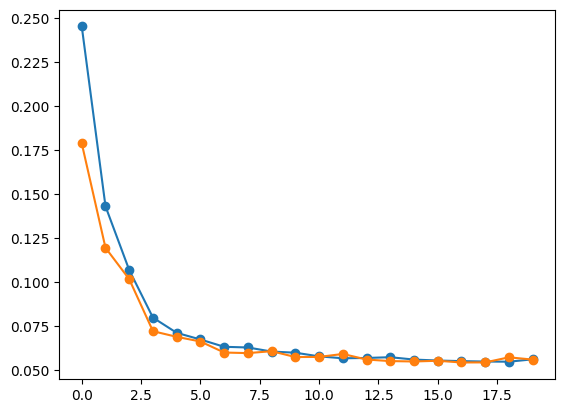

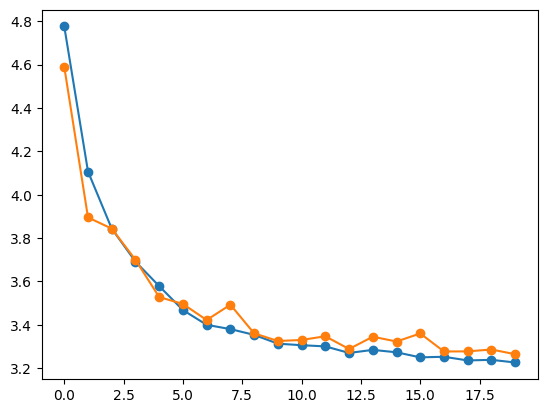

In [66]:
print(history.history.keys())
plt.figure()
plt.plot(history.history['loss'], label='train', marker='o')
plt.plot(history.history['val_loss'], label='val', marker='o')

plt.figure()
plt.plot(history.history['mae'], label='train', marker='o')
plt.plot(history.history['val_mae'], label='val', marker='o')

plt.figure()
plt.plot(history.history['MeanGradientError'], label='train', marker='o')
plt.plot(history.history['val_MeanGradientError'], label='val', marker='o')

## Testing

In [76]:
outputs = net.predict(test_dataset)

26/26 [==============================] - 3s 97ms/step


Text(0.5, 1.0, 'Ground Truth')

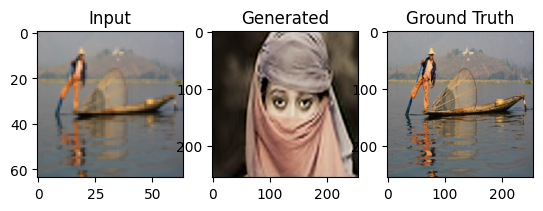

In [79]:

    x, y = test_generator[12]
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(x)
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(outputs[i])
    plt.title("Generated")
    plt.subplot(1, 3, 3)
    plt.imshow(y)
    plt.title("Ground Truth")


pip install numpy==1.23.0
